In [1]:
%matplotlib inline

import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/apple1/TFCA/nengo-dl/nengo_dl/__init__.py:17: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  warnings.warn("No GPU support detected. It is recommended that you "


In [2]:
lif_params = {
    'tau_rc': 0.07,
    'tau_ref': 0.0005,
    'amplitude': 0.01
}

# lif parameters
lif_neurons = nengo.LIF(**lif_params)

# softlif parameters (lif parameters + sigma)
softlif_neurons = nengo_dl.SoftLIFRate(**lif_params,
                                       sigma=0.002)

# ensemble parameters
ens_params = dict(max_rates=nengo.dists.Choice([100]), intercepts=nengo.dists.Choice([0]))

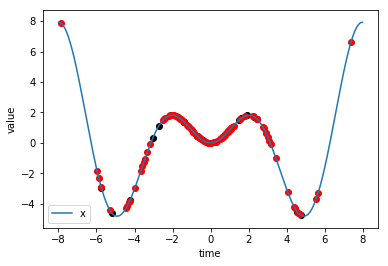

In [3]:
np.random.seed(42)
train = 3. * np.random.randn(20)
test = 3. * np.random.randn(100)
target = np.linspace(-8, 8, 1000)
y = lambda x: x * np.sin(x)
plt.figure()
plt.plot(target, y(target), label="x")
plt.scatter(train,y(train), color='black')
plt.scatter(test,y(test), color='red')
plt.xlabel("time")
plt.ylabel("value")
plt.legend();

In [4]:
drop_p = 0.05

In [5]:
def build_network(neuron_type, n_units=50, use_dropout=True):
    with nengo.Network() as net:
        
        #net.config[nengo.Connection].synapse = None
        #nengo_dl.configure_settings(trainable=False)

        inp = nengo.Node([0])
        
        # add a dropout layer
        x = nengo_dl.tensor_layer(inp, tf.layers.dropout, rate=drop_p, training=use_dropout)
        
        x = nengo_dl.tensor_layer(x, tf.layers.dense, units=n_units, shape_in=(1,))
        x = nengo_dl.tensor_layer(x, neuron_type, **ens_params)
        
        # add a dropout layer
        x = nengo_dl.tensor_layer(x, tf.layers.dropout, rate=drop_p, training=use_dropout)
        
        x = nengo_dl.tensor_layer(x, tf.layers.dense, units=n_units)
        x = nengo_dl.tensor_layer(x, neuron_type, **ens_params)
        
        x = nengo_dl.tensor_layer(x, tf.layers.dense, units=1)

    return net, inp, x



In [7]:
# construct the network
net, inp, out = build_network(softlif_neurons)
with net:
    in_p = nengo.Probe(inp)
    out_p = nengo.Probe(out)

# construct the simulator
minibatch_size = 5
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [8]:
traint = train[:,None,None]
testt = test[:,None,None]
train_x = {inp: traint}
train_y = {out_p: y(traint)}
test_x = {inp: testt}
test_y = {out_p: y(testt)}

In [9]:
def objective(x, y):
    return tf.losses.mean_squared_error(x,y)

In [10]:
#opt = tf.train.MomentumOptimizer(learning_rate=0.0002, momentum=0.9, use_nesterov=True)
opt = tf.train.RMSPropOptimizer(1e-3)
#opt = tf.train.AdadeltaOptimizer(learning_rate=1)
#opt = tf.train.AdamOptimizer()

In [11]:
print("error before training: ", sim.loss(test_x, test_y, objective=objective))

do_training = False
if do_training:
    sim.train(train_x, train_y, opt, n_epochs=1000, objective=objective, summaries=['loss'])
    # save the parameters to file
    sim.save_params("./uncertain_params")
else:
    # load parameters
    sim.load_params("./uncertain_params")
    
print("error after training:", sim.loss(test_x, test_y, objective=objective))


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmp9_dhuv07/tmp


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmp9_dhuv07/tmp


error before training:  4.368662095814943
INFO:tensorflow:Restoring parameters from ./uncertain_params


INFO:tensorflow:Restoring parameters from ./uncertain_params


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmp7czo2sxu/tmp


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmp7czo2sxu/tmp


error after training: 4.621305658970959


In [18]:
T = 10
outputs = np.zeros((T,target.size))
for t in range(T):
    for i in range(0,target.size,minibatch_size):
        sim.run_steps(1,input_feeds={inp: target[i:i+minibatch_size,None,None]})
        sim.soft_reset()
    outputs[t] = sim.data[out_p].transpose(1,0,2).reshape((1000,))
    sim.soft_reset(include_trainable=False, include_probes=True)

Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00          

In [19]:
predictive_mean = np.mean(outputs, axis=0)
predictive_variance = np.var(outputs, axis=0)
#tau = l**2 * (1 - drop_p) / (2 * N * model.weight_decay)
#predictive_variance += tau**-1


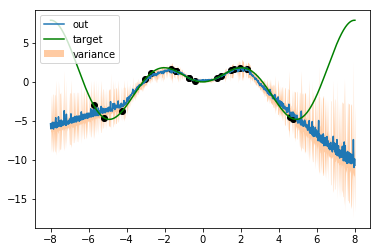

In [20]:
plt.plot(target,predictive_mean,label='out')
plt.fill_between(target, predictive_mean-2*np.sqrt(predictive_variance), predictive_mean+2*np.sqrt(predictive_variance),
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', linewidth=0, label='variance')
plt.plot(target,y(target),label='target', color='green')
plt.scatter(train,y(train), color='black')
plt.legend(loc='upper left')



In [720]:
sim.close()

## Spiking

In [721]:
net, inp, out = build_network(lif_neurons, use_dropout=False)
with net:
    in_p = nengo.Probe(inp)
    out_p = nengo.Probe(out)

sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)#, unroll_simulation=10)
sim.load_params("./uncertain_params")

Building network
Build finished in 0:00:00 
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
INFO:tensorflow:Restoring parameters from ./uncertain_params


INFO:tensorflow:Restoring parameters from ./uncertain_params


In [722]:
n_steps = 100
test_inputs_time = {inp: np.tile(v, (1, n_steps, 1)) for v in test_x.values()}
test_targets_time = {out_p: np.tile(v, (1, n_steps, 1)) for v in test_y.values()}

print("spiking neuron error: %.2f%%" % sim.loss(test_inputs_time, test_targets_time,
                                                objective='mse'))

INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmpx_fpgss0/tmp


INFO:tensorflow:Restoring parameters from /var/folders/qd/c965ltdd52v33r5tcsy78dsh0000gr/T/tmpx_fpgss0/tmp


spiking neuron error: 26.07%


In [723]:
target_steps = {inp: np.tile(target[:,None,None], (1, n_steps, 1))}

In [724]:
spiking_outputs = np.zeros((target.size,n_steps))
spiking_inputs = np.zeros((target.size,n_steps))
for i in range(0,target.size,minibatch_size):
    sim.soft_reset(include_trainable=False, include_probes=True)
    sim.run_steps(n_steps,input_feeds={inp: target_steps[inp][i:i+minibatch_size,:]})
    spiking_outputs[i:i+minibatch_size] = sim.data[out_p][...,0]
    spiking_inputs[i:i+minibatch_size] = sim.data[in_p][...,0]


Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00                                                 
Simulation finished in 0:00:00          

In [725]:
#predictive_mean = np.mean([np.mean(spiking_outputs[:,-i:],axis=1) for i in range(0,n_steps,10)],axis=0)
#predictive_variance = np.var([np.var(spiking_outputs[:,-i:],axis=1) for i in range(0,n_steps,10)],axis=0)
predictive_mean = np.mean(spiking_outputs[:,-50:],axis=1)
predictive_variance = np.var(spiking_outputs[:,-50:],axis=1)

/Users/apple1/TFCA/nengo-dl/nengo_dl/simulator.py:1223: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x12c739978>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  "are properly freed." % self.model, RuntimeWarning)


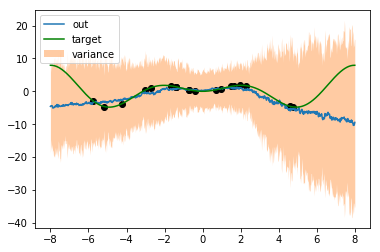

In [729]:
plt.plot(target,predictive_mean,label='out')
#plt.plot(target,spiking_outputs[:,-1],label='out')
plt.fill_between(target, predictive_mean-2*np.sqrt(predictive_variance), predictive_mean+2*np.sqrt(predictive_variance),
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', linewidth=0, label='variance')
plt.plot(target,y(target),label='target', color='green')
plt.scatter(train,y(train), color='black')
#plt.ylim([-20,20])
plt.legend(loc='upper left')

In [565]:
#print(spiking_outputs[100])
print(target[500])
print(y(target[500]))
np.mean([np.mean(spiking_outputs[500,-i:]) for i in range(0,500,10)])

0.008008008008008716
6.412750685435572e-05


0.6006903821092708

In [334]:
sim.close()

In [145]:
sim.soft_reset(include_trainable=False, include_probes=True)

# Tensorflow Test

In [ ]:
for i in range(0,target.size,minibatch_size):
        sim.run_steps(1,input_feeds={inp: target[i:i+minibatch_size,None,None]})
    outputs[t] = sim.data[out_p].transpose(1,0,2).reshape((1000,))

In [ ]:
sess = tf.InteractiveSession()
place_x = tf.placeholder(tf.float32, [None, 1])
place_y = tf.placeholder(tf.float32, [None, 1])
hidden = tf.layers.dense(place_x, units = 20, activation = tf.nn.relu)
output = tf.layers.dense(hidden, units = 1, activation = tf.identity)
cost = tf.losses.mean_squared_error(output, place_y)
optimize = tf.train.AdamOptimizer().minimize(cost)

In [ ]:
# Train model 
sess.run(tf.global_variables_initializer())
for i in range(1000):
    feed_dict = {
        place_x: traint[...,0], 
        place_y: y(traint[...,0])
    }
    _cost, _hid_out, _final_out, _ = sess.run([cost, hidden, output, optimize], feed_dict=feed_dict)
print(_cost)


In [ ]:
plt.scatter(traint[...,0],y(traint[...,0]),label='target')
plt.scatter(traint[...,0],_final_out, label = 'out')